In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
from chainconsumer import ChainConsumer
from chainconsumer import Chain
import numdifftools as nd 
import sacc
import sys

# covariance - Charlie's version of TJPCov
MODULE_PATH = "/home/c2042999/TJPCov/tjpcov/__init__.py"
MODULE_NAME = "tjpcov"
import importlib
spec = importlib.util.spec_from_file_location(MODULE_NAME, MODULE_PATH)
module = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = module 
spec.loader.exec_module(module)
from tjpcov.covariance_calculator import CovarianceCalculator


# SRD Binning
import srd_redshift_distributions as srd
import binning

In [2]:
cosmo_universe = ccl.Cosmology(Omega_c = 0.27, 
                          Omega_b = 0.046, 
                          h = 0.7, 
                          n_s = 0.974,
                          A_s = 2.01e-9)


In [3]:
# Define the redshift interval and forecast years
redshift_range = np.linspace(0.01, 3.5, 500)
forecast_years = ["1", "10"]  # Assuming integers are appropriate

# Create a dictionary to store the redshift distributions
# for each forecast year and galaxy sample
redshift_distribution = {
    "sources": {},
    "lenses": {}
}

for year in forecast_years:
    source_dist = srd.SRDRedshiftDistributions(redshift_range, 
                                               galaxy_sample="source_sample",
                                               forecast_year=year)
    lens_dist = srd.SRDRedshiftDistributions(redshift_range, 
                                             galaxy_sample="lens_sample",
                                             forecast_year=year)

    redshift_distribution["sources"][year] = source_dist.get_redshift_distribution(normalised=True,
                                                                                   save_file=False)
    redshift_distribution["lenses"][year] = lens_dist.get_redshift_distribution(normalised=True,
                                                                                save_file=False)

# Uncomment to check if the dictionary is populated correctly
# print(redshift_distribution["sources"].keys())


bins = {
    "sources": {},
    "lenses": {}
}

# Perform the binning procedure
for year in forecast_years:
    bins["sources"][year] = binning.Binning(redshift_range, 
                                            redshift_distribution["sources"][year],
                                            year).source_bins(normalised=True,
                                                              save_file=False)
    bins["lenses"][year] = binning.Binning(redshift_range, 
                                           redshift_distribution["lenses"][year],
                                           year).lens_bins(normalised=True,
                                                           save_file=False)


#(5, 256)
Binned_distribution_lens = [list(bins["lenses"]["1"].items())[0][1]]
for i in range(4):
    Binned_distribution_lens = np.append(Binned_distribution_lens,\
               [list(bins["lenses"]["1"].items())[i+1][1]], axis=0)

Binned_distribution_source = [list(bins["sources"]["1"].items())[0][1]]
for i in range(4):
    Binned_distribution_source = np.append(Binned_distribution_source,\
               [list(bins["sources"]["1"].items())[i+1][1]], axis=0)
    
print(Binned_distribution_lens.shape)
print(Binned_distribution_source.shape)
print(redshift_range.shape)

(5, 500)
(5, 500)
(500,)


In [56]:
# Match SRD

Bias_distribution = np.array([1.562362*np.ones(len(redshift_range)),
                             1.732963*np.ones(len(redshift_range)),
                             1.913252*np.ones(len(redshift_range)),
                             2.100644*np.ones(len(redshift_range)),
                             2.293210*np.ones(len(redshift_range))])
Bias_distribution_vals = [1.562362, 1.732963, 1.913252, 2.100644, 2.293210]

In [5]:
z_s = redshift_range; z_l = redshift_range
dNdz_s = Binned_distribution_source.T; dNdz_l = Binned_distribution_lens.T

In [9]:
"""Check we match SRD"""
def bins(ell_min, ell_max, ell_bin_num):

    # define quantities for binning in ell
    ell_binned_limits = np.linspace(np.log10(ell_min),np.log10(ell_max),num=ell_bin_num + 1)
    bin_edge1 = ell_binned_limits[:-1]
    bin_edge2 = ell_binned_limits[1:]
    ell_binned = 10**((bin_edge1 + bin_edge2) / 2)
    # Repeat ell_binned over all redshift bins, so that len(ell_binned)=len(C_ell_array)
    return ell_binned

# ell binning for shear
print(np.loadtxt("/home/c2042999/PCA_project/ell-values").shape)

print(bins(20, 1478.5, 13))

(20,)
[  23.59970561   32.85941027   45.75230138   63.70391509   88.6991184
  123.5015712   171.95929751  239.43015228  333.37422663  464.17869231
  646.30628639  899.89442158 1252.98173181]


In [10]:
ell_path = "/home/c2042999/PCA_project/ell-values"
ell = np.loadtxt(ell_path)
print(ell)
ell=ell[np.where(ell<2000)]
print(ell.shape)
theta_deg = np.logspace(-1, np.log10(5.), len(ell)) # Theta is in degrees

[   23.5997     32.8594     45.75227    63.70386    88.69901   123.5014
   171.959     239.4297    333.3735    464.1775    646.3045    899.8917
  1252.978    1744.602    2429.122    3382.225    4709.291    6557.052
  9129.808   12712.02   ]
(14,)


In [11]:
#read covariances from clustering file
cov_path = 'cov_3x2pt_Y1_May2022 1.txt'
cov = np.loadtxt(cov_path)

### Get Covariance

In [80]:
"""Define sacc file - Cl^{ij}(ell) for some ell bins and redshift bins"""
# My redshifts (for now)
src0 = Binned_distribution_source[0]
src1 = Binned_distribution_source[1]
src2 = Binned_distribution_source[2]
src3 = Binned_distribution_source[3]
src4 = Binned_distribution_source[4]
z_src = redshift_range

lens0 = Binned_distribution_lens[0]
lens1 = Binned_distribution_lens[1]
lens2 = Binned_distribution_lens[2]
lens3 = Binned_distribution_lens[3]
lens4 = Binned_distribution_lens[4]
z_lens = redshift_range

#ell_bins = ell_mockdata[:ell_bin_num_mockdata]
ell_bins = ell
print(ell_bins.shape)

# z binning 

src_bins = [src0, src1, src2, src3, src4]
lens_bins = [lens0, lens1, lens2, lens3, lens4]

s = sacc.Sacc()

n = 0
for i, bin1 in enumerate(src_bins):
    s.add_tracer('NZ', 'src%d'%i, z=z_src, nz=bin1)
    for j, bin2 in enumerate(src_bins):
        if j >= i:
            n +=1
            # construct Cl_gM for sacc file
            shearA = ccl.WeakLensingTracer(cosmo_universe, dndz=(z_src, bin1), has_shear=True)
            shearB = ccl.WeakLensingTracer(cosmo_universe, dndz=(z_src, bin2), has_shear=True)
    
            Cl = ccl.angular_cl(cosmo_universe, shearA, shearB, ell_bins) 
            # bin ell
    
            s.add_ell_cl('galaxy_shear_cl_ee', 'src%d'%i, 
                                'src%d'%j, ell_bins, Cl, tracers_later=True)

for i, bin1 in enumerate(lens_bins):
    n +=1
    s.add_tracer('NZ', 'lens%d'%i, z=z_lens, nz=bin1)
    # construct Cl_gM for sacc file
    shearA = ccl.NumberCountsTracer(cosmo_universe, dndz=(z_lens, bin1), bias=(z_lens, Bias_distribution[i]), has_rsd=False)
    # bias=(z_lens, Bias_distribution[i])
    Cl = ccl.angular_cl(cosmo_universe, shearA, shearA, ell_bins) 
    # bin ell

    s.add_ell_cl('galaxy_density_cl', 'lens%d'%i, 
                            'lens%d'%i, ell_bins, Cl, tracers_later=True)
    


for i, bin1 in enumerate(lens_bins):
    for j, bin2 in enumerate(src_bins):
        s.add_tracer('NZ', 'src%d'%j, z=z_src, nz=bin2)
        if j - 1 > i or (j == 4 and i == 3):
            n +=1
            s.add_tracer('NZ', 'lens%d'%i, z=z_lens, nz=bin1)
            # construct Cl_gM for sacc file
            shearA = ccl.NumberCountsTracer(cosmo_universe, dndz=(z_lens, bin1), bias=(z_lens, Bias_distribution[i]), has_rsd=False)
            shearB = ccl.WeakLensingTracer(cosmo_universe, dndz=(z_src, bin2), has_shear=True)
        
            Cl = ccl.angular_cl(cosmo_universe, shearA, shearB, ell_bins) 
            # bin ell
        
            s.add_ell_cl('galaxy_shearDensity_cl_e', 'lens%d'%i, 
                                'src%d'%j, ell_bins, Cl, tracers_later=True)
print(n)

s.save_fits('/home/c2042999/PCA_project/Covariance_understanding/SRD_specs/cl_and_xi_data.fits', overwrite=True)

(14,)
27


In [81]:
s = sacc.Sacc.load_fits("/home/c2042999/PCA_project/Covariance_understanding/SRD_specs/cl_and_xi_data.fits")

In [82]:
config = '/home/c2042999/PCA_project/Covariance_understanding/SRD_specs/Fourier_cosmic_shear_gauss.yaml'

gauss_calc = CovarianceCalculator(config)

gauss_calc.config


{'tjpcov': {'sacc_file': '/home/c2042999/PCA_project/Covariance_understanding/SRD_specs/cl_and_xi_data.fits',
  'cosmo': '/home/c2042999/PCA_project/Covariance_understanding/SRD_specs/cosmo_MCMC.yaml',
  'cov_type': ['FourierGaussianFsky'],
  'Ngal_lens0': 3.6,
  'Ngal_lens1': 3.6,
  'Ngal_lens2': 3.6,
  'Ngal_lens3': 3.6,
  'Ngal_lens4': 3.6,
  'Ngal_src0': 1.904,
  'Ngal_src1': 1.904,
  'Ngal_src2': 1.904,
  'Ngal_src3': 1.904,
  'Ngal_src4': 1.904,
  'sigma_e_src0': 0.26,
  'sigma_e_src1': 0.26,
  'sigma_e_src2': 0.26,
  'sigma_e_src3': 0.26,
  'sigma_e_src4': 0.26,
  'bias_lens0': 1.562362,
  'bias_lens1': 1.732963,
  'bias_lens2': 1.913252,
  'bias_lens3': 2.100644,
  'bias_lens4': 2.29321,
  'IA': 0.8},
 'GaussianFsky': {'fsky': 0.4363}}

In [83]:
# get matrix
gauss_cov = gauss_calc.get_covariance()

Computing independent covariance blocks
('lens0', 'lens0') ('lens0', 'lens0')


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/home/c2042999/TJPCov/tjpcov/covariance_builder.py:897: UserWarning: Missing n_ell_coupled info for some tracers in the sacc file. You will have to pass it withthe cache
  warnings.warn(


('lens0', 'lens0') ('lens1', 'lens1')
('lens0', 'lens0') ('lens2', 'lens2')
('lens0', 'lens0') ('lens3', 'lens3')
('lens0', 'lens0') ('lens4', 'lens4')
('lens0', 'lens0') ('lens0', 'src2')
('lens0', 'lens0') ('lens0', 'src3')
('lens0', 'lens0') ('lens0', 'src4')
('lens0', 'lens0') ('lens1', 'src3')
('lens0', 'lens0') ('lens1', 'src4')
('lens0', 'lens0') ('lens2', 'src4')
('lens0', 'lens0') ('lens3', 'src4')
('lens0', 'lens0') ('src0', 'src0')
('lens0', 'lens0') ('src0', 'src1')
('lens0', 'lens0') ('src0', 'src2')
('lens0', 'lens0') ('src0', 'src3')
('lens0', 'lens0') ('src0', 'src4')
('lens0', 'lens0') ('src1', 'src1')
('lens0', 'lens0') ('src1', 'src2')
('lens0', 'lens0') ('src1', 'src3')
('lens0', 'lens0') ('src1', 'src4')
('lens0', 'lens0') ('src2', 'src2')
('lens0', 'lens0') ('src2', 'src3')
('lens0', 'lens0') ('src2', 'src4')
('lens0', 'lens0') ('src3', 'src3')
('lens0', 'lens0') ('src3', 'src4')
('lens0', 'lens0') ('src4', 'src4')
('lens1', 'lens1') ('lens1', 'lens1')
('lens1', '

In [87]:
print(cov.shape)
print(14*27)
print(540/27)

(540, 540)
378
20.0


In [89]:
# * each tomographic bin consists of 20 l-values ranging from 20-15000, with l-values >3000 being set to zero
Cell_bins_lensing=20
Cell_bins_lensing_cut=14

cov_lensing_auto_cut=np.zeros((Cell_bins_lensing_cut*27,Cell_bins_lensing_cut*27))

for i in range(Cell_bins_lensing_cut*27):
    for j in range(Cell_bins_lensing_cut*27):
        i_start=i*Cell_bins_lensing
        i_end=i*Cell_bins_lensing+Cell_bins_lensing_cut
        j_start=j*Cell_bins_lensing
        j_end=j*Cell_bins_lensing+Cell_bins_lensing_cut
        cov_lensing_auto_cut[i*Cell_bins_lensing_cut:(i+1)*Cell_bins_lensing_cut,j*Cell_bins_lensing_cut:(j+1)*Cell_bins_lensing_cut]=cov[i_start:i_end,j_start:j_end]

In [90]:
gauss_cov_rotated = np.zeros((len(gauss_cov),len(gauss_cov)))
n_ellbins = len(ell_bins)
n_zbins = int(len(gauss_cov)/len(ell_bins))
gauss_cov_rotated[int(22*n_ellbins):,int(22*n_ellbins):] = gauss_cov[:int(5*n_ellbins),:int(5*n_ellbins)]
gauss_cov_rotated[int(15*n_ellbins):int(22*n_ellbins),int(15*n_ellbins):int(22*n_ellbins)] = gauss_cov[int(5*n_ellbins):int(12*n_ellbins),int(5*n_ellbins):int(12*n_ellbins)]
gauss_cov_rotated[:int(15*n_ellbins),:int(15*n_ellbins)] = gauss_cov[int(12*n_ellbins):,int(12*n_ellbins):]

gauss_cov_rotated[int(15*n_ellbins):int(22*n_ellbins),int(22*n_ellbins):] = gauss_cov[int(5*n_ellbins):int(12*n_ellbins),:int(5*n_ellbins)]
gauss_cov_rotated[int(22*n_ellbins):,int(15*n_ellbins):int(22*n_ellbins)] = gauss_cov[:int(5*n_ellbins),int(5*n_ellbins):int(12*n_ellbins)]

gauss_cov_rotated[:int(15*n_ellbins),int(22*n_ellbins):] = gauss_cov[int(12*n_ellbins):,:int(5*n_ellbins)]
gauss_cov_rotated[int(22*n_ellbins):,:int(15*n_ellbins)] = gauss_cov[:int(5*n_ellbins),int(12*n_ellbins):]

gauss_cov_rotated[:int(15*n_ellbins),int(15*n_ellbins):int(22*n_ellbins)] = gauss_cov[int(12*n_ellbins):,int(5*n_ellbins):int(12*n_ellbins)]
gauss_cov_rotated[int(15*n_ellbins):int(22*n_ellbins),:int(15*n_ellbins)] = gauss_cov[int(5*n_ellbins):int(12*n_ellbins),int(12*n_ellbins):]

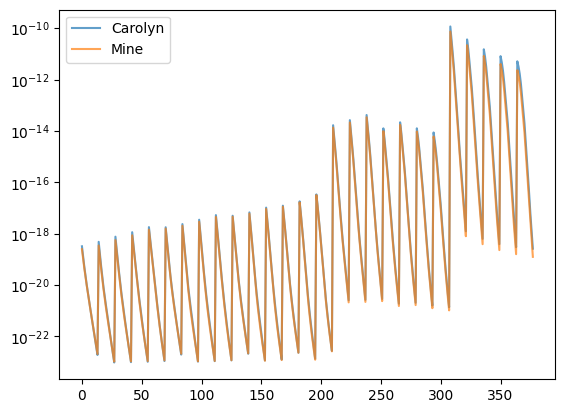

In [91]:
plt.plot(np.diag(cov_lensing_auto_cut), alpha = 0.7, label ="Carolyn")
plt.plot(np.diag(gauss_cov_rotated), alpha = 0.7, label ="Mine")
plt.yscale("log")
plt.legend()

### Cut Covariance

In [19]:
# * each tomographic bin consists of 20 l-values ranging from 20-15000, with l-values >3000 being set to zero
Cell_bins_lensing=20
Cell_bins_lensing_cut=14

cov_lensing_auto_cut=np.zeros((Cell_bins_lensing_cut*27,Cell_bins_lensing_cut*27))

for i in range(Cell_bins_lensing_cut*27):
    for j in range(Cell_bins_lensing_cut*27):
        i_start=i*Cell_bins_lensing
        i_end=i*Cell_bins_lensing+Cell_bins_lensing_cut
        j_start=j*Cell_bins_lensing
        j_end=j*Cell_bins_lensing+Cell_bins_lensing_cut
        cov_lensing_auto_cut[i*Cell_bins_lensing_cut:(i+1)*Cell_bins_lensing_cut,j*Cell_bins_lensing_cut:(j+1)*Cell_bins_lensing_cut]=cov[i_start:i_end,j_start:j_end]

In [128]:
inv = np.linalg.inv(cov_lensing_auto_cut)
print(np.shape(inv))

(378, 378)


### Fisher

In [129]:
#dictionary of fiducial cosmology
p_dict =    {"ns" : 0.96,
             "s8" : 0.769,
             "h" : 0.7,
             "OmegaM" : 0.3,
             "OmegaB" : 0.05,
             "b1" : 1.562362,
             "b2" : 1.732963,
             "b3" : 1.913252,
             "b4" : 2.100644,
             "b5" : 2.293210
             }

In [130]:
ggl_bins=[[0,2],[0,3],[0,4],[1,3],[1,4],[2,4],[3,4]] #ggl bins as recommended is lsst desc srd
b= np.ones(len(z_l)) #linear galaxy bias

In [131]:
def C_ell_lenses(cosmology, z, dNdz_i, dNdz_j, bias, ell): 
    tracer_i = ccl.NumberCountsTracer(cosmology, has_rsd=False, dndz=(z, dNdz_i), bias=(z, bias))
    tracer_j = ccl.NumberCountsTracer(cosmology, has_rsd=False, dndz=(z, dNdz_j), bias=(z, bias))
    C_ell = ccl.angular_cl(cosmology, tracer_i, tracer_j, ell)
    return C_ell

In [132]:
def C_ell_srcs(cosmology, z, dNdz_i, dNdz_j, ell):
    tracer_i = ccl.WeakLensingTracer(cosmology, dndz=(z, dNdz_i))
    tracer_j = ccl.WeakLensingTracer(cosmology, dndz=(z, dNdz_j))
    C_ell = ccl.angular_cl(cosmology, tracer_i, tracer_j, ell)
    return C_ell

In [133]:
def C_ell_cross(cosmology, z_i, dNdz_i, z_j, dNdz_j, bias, ell): 
    tracer_i = ccl.NumberCountsTracer(cosmology, has_rsd=False, dndz=(z_i, dNdz_i), bias=(z_i, bias))
    tracer_j = ccl.WeakLensingTracer(cosmology, dndz=(z_j, dNdz_j))
    C_ell = ccl.angular_cl(cosmology, tracer_i, tracer_j, ell)
    return C_ell

In [134]:
def P_ell(theta, h): 
    OmegaM=p_dict["OmegaM"]+h*theta[0]*p_dict["OmegaM"]
    OmegaB=p_dict["OmegaB"]+h*theta[1]*p_dict["OmegaB"]
    OmegaC= OmegaM - OmegaB  
    cosmo=ccl.Cosmology(Omega_c = OmegaC, 
                        Omega_b = OmegaB, 
                        n_s = p_dict["ns"] + h*theta[3]*p_dict["ns"], 
                        sigma8 = p_dict["s8"] + h*theta[2]*p_dict["s8"], 
                        h = p_dict["h"] + h*theta[4]*p_dict["h"])
    
    b_vals = [p_dict["b1"] + h*theta[5]*p_dict["b1"], 
              p_dict["b2"] + h*theta[6]*p_dict["b2"], 
              p_dict["b3"] + h*theta[7]*p_dict["b3"], 
              p_dict["b4"] + h*theta[8]*p_dict["b4"], 
              p_dict["b5"] + h*theta[9]*p_dict["b5"]]
    P_ell = []
    for i in range (0, 5): 
        j=i
        while j!=5: 
            P_ell.extend(C_ell_srcs(cosmo, z_s, dNdz_s[:,i], dNdz_s[:,j], ell))
            j=j+1
            
    for m in range (0, len(ggl_bins)): 
        i,j = ggl_bins[m]
        b_g = b_vals[i]*b
        P_ell.extend(C_ell_cross(cosmo, z_l, dNdz_l[:,i], z_s, dNdz_s[:,j],b_g, ell))
    
    for i in range (0,5): 
        b_g = b_vals[i]*b
        P_ell.extend(C_ell_lenses(cosmo, z_l, dNdz_l[:,i], dNdz_l[:,i], b_g, ell))
        
    P_ell = np.array(P_ell)
    return P_ell

In [135]:
def d(theta, h):
    P_ell_up = P_ell(theta, h)
    P_ell_down = P_ell(theta, -h)
    dP = (P_ell_up-P_ell_down)/(2*h)
    return dP

In [136]:
def R_e(theta, h):
    dP_h2 = d(theta,h/2)
    dP_h = d(theta,h)
    A = (4*dP_h2 - dP_h)/3
    return A 

The P_ell is differentiated by each parameter independently, by having an identity matrix theta that means every parameter is changed by 1 * h * parameter while all others are changed by 0 * h * parameter. In this code there is a set step size h over which we carry out the numerical differentiation. 

In [137]:
n_p = 10 #number of parameters interested in
theta = np.identity(n_p) 
h = 0.05

F=np.zeros(shape=(n_p, n_p))

for i in range (0, n_p): 
    for j in range (0, n_p):
        d_i = d(theta[i], h) #differentiate by parameter i of 10
        d_j = d(theta[j], h) #differentiate by parameter j of 10
        F[i,j] = np.matmul(np.matmul(d_i, inv), d_j)
        
C = np.linalg.inv(F)

## Fisher of priors

In [138]:
n_prior = 0.015
sigma8_prior = 0.01
h_prior = 3
omegam_prior = 0.05
omegab_prior = 0.2
b1_prior = 1
b2_prior = 1
b3_prior = 1
b4_prior = 1
b5_prior = 1

priors = np.square([omegam_prior,omegab_prior,sigma8_prior,n_prior , h_prior, b1_prior, b2_prior, b3_prior, b4_prior, b5_prior])


C_prior = np.diag(priors)
F_prior = np.linalg.inv(C_prior)

## Plot full covariance matrix 

In [139]:
F_full = F + F_prior
C = np.linalg.inv(F_full)

In [140]:
fiducial_params=[p_dict["OmegaM"],  p_dict["OmegaB"],p_dict["s8"],p_dict["ns"], p_dict['h'], p_dict["b1"], p_dict["b2"], p_dict["b3"], p_dict["b4"], p_dict["b5"]]

chain = ChainConsumer()
param_strings=[r'$\Omega_M$', r'$\Omega_B$',r'$\sigma_8$',r'$n_s$', r'h', r'$b_1$', r'$b_2$', r'$b_3$', r'$b_4$', r'$b_5$']

chain2 = Chain.from_covariance(
    fiducial_params[:5], C[:5,:5],
    plot_contour=True, columns=param_strings[:5], 
    color='blue', name=r'$b_g=1.562362$', 
    linewidth=1, linestyle='-'
)
chain.add_chain(chain2)

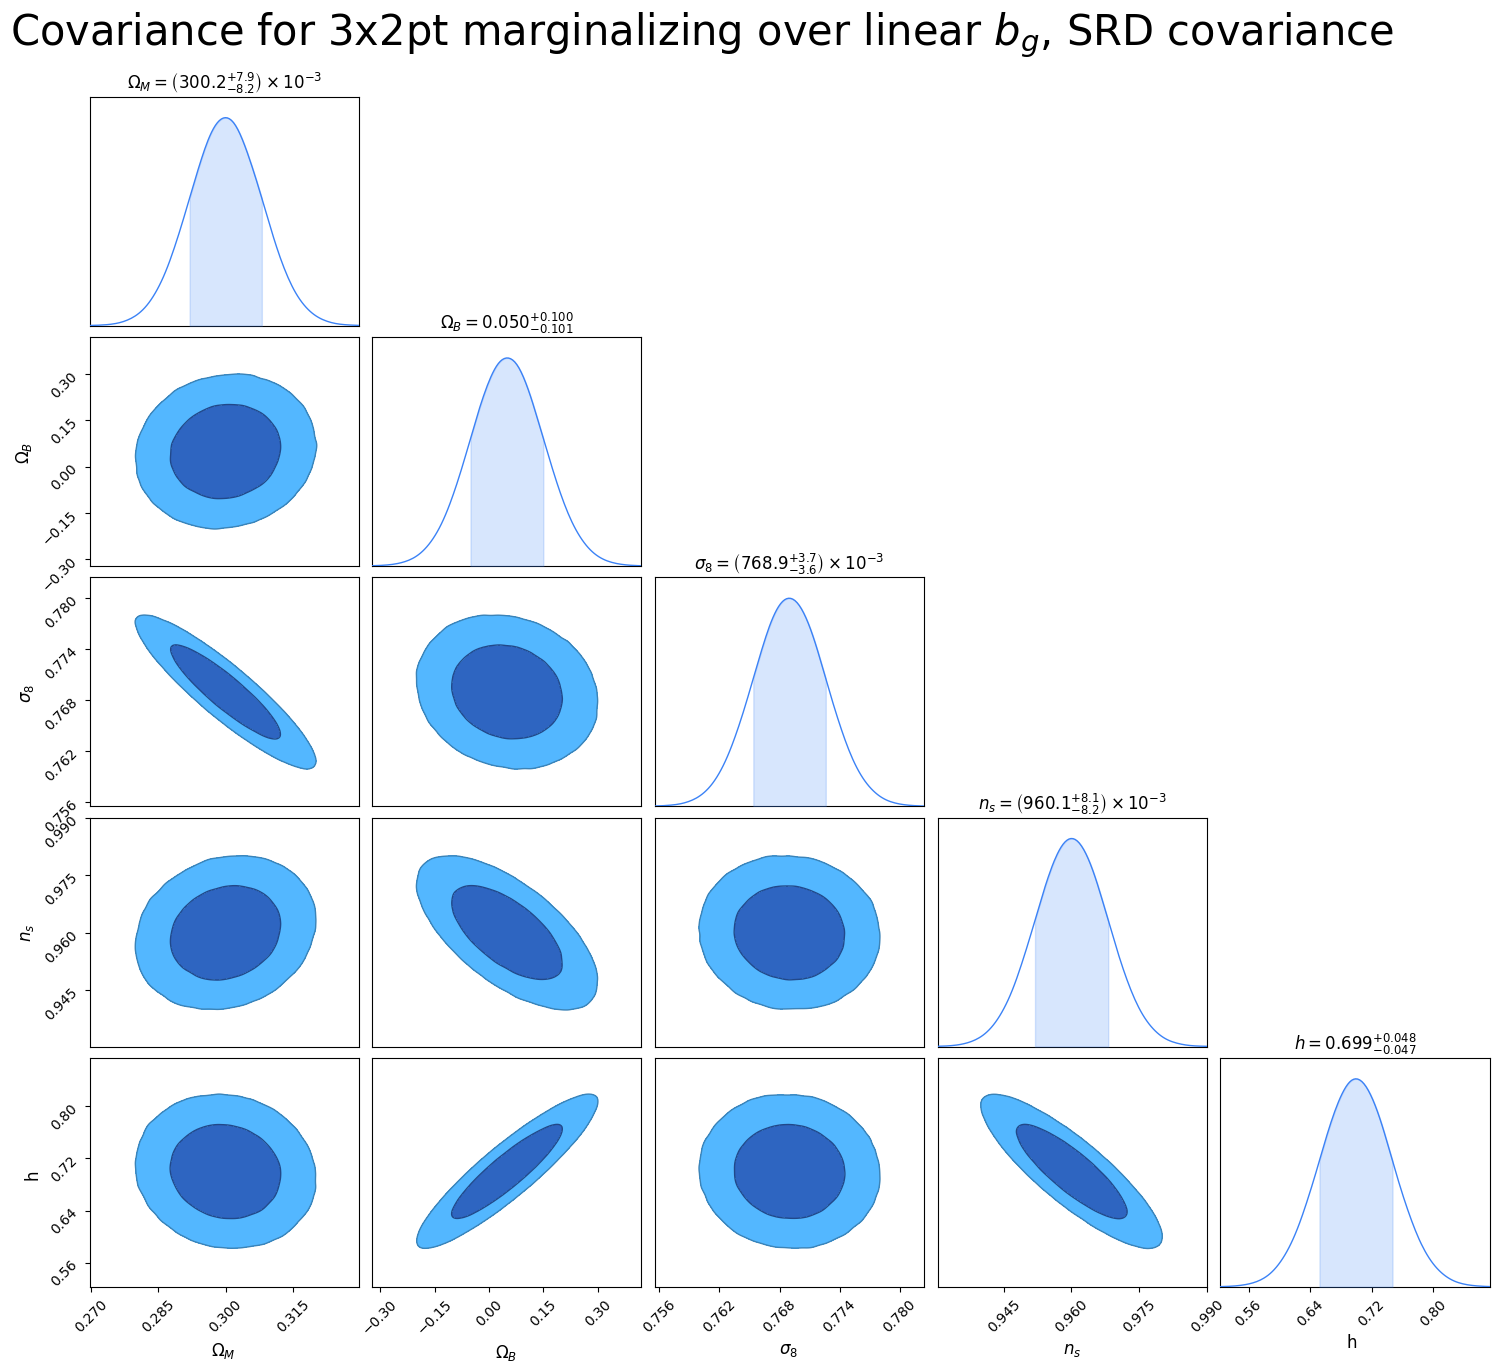

In [141]:

#chain.add_covariance(fiducial_params, C,  plot_contour=True, parameters=param_strings, color='blue', name=r'$b_g=1.562362$', linewidth=1, linestyle='-')
#chain.configure(tick_font_size=10, label_font_size=13, flip=True, sigma2d=False, sigmas=[1,2], shade=True, bar_shade=False, smooth=1, legend_artists=True)

fig = chain.plotter.plot()
fig.set_size_inches(4.5 + fig.get_size_inches())
plt.subplots_adjust(bottom=0.25, left=0.15, right=0.95, top=0.93)
plt.suptitle("Covariance for 3x2pt marginalizing over linear $b_g$, SRD covariance", fontsize=30) 
plt.show()